In [5]:
import shapefile as shp
import shapely
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
shapely.__version__
#shapely.geos_capi_version_string  
import geopandas as gpd
import os
import sys
sys.path.append('../')
from atlantic_hurricane import eccc_shapefiles

In [2]:
sns.set(style="whitegrid", palette="pastel", color_codes=True) 
sns.mpl.rc("figure", figsize=(10,6))

In [3]:
#opening the vector map
shp_path = eccc_shapefiles.dl_shapefile('20220921_1200Z_FIONA.err.shp')
#reading the shape file by using reader function of the shape lib
sf = shp.Reader(shp_path)

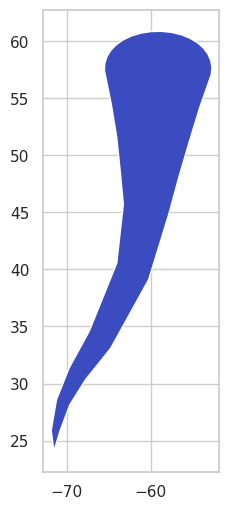

In [4]:
err1= gpd.read_file(shp_path)
err1.plot(cmap= "coolwarm")
plt.show()

In [6]:
#data_path= r"C:\Users\ceboigbe.adm\Documents\GitHub\atlantic-hurricane-dashboard\shapefiles\atlantic_canada_boundary.shp"
shapefiles_dir = os.path.abspath(os.path.join('..', 'shapefiles'))
data_path = os.path.join(shapefiles_dir, 'atlantic_canada_boundary.shp')
atlantic_data=gpd.read_file(data_path)

can_hurricane_boundary= os.path.join(shapefiles_dir, 'hurricane_response_boundary.shp')
can_hurricane=gpd.read_file(can_hurricane_boundary)

In [8]:
intersect_overlay_1= gpd.overlay(atlantic_data, err1, how='intersection')
intersect_overlay= gpd.overlay(intersect_overlay_1, can_hurricane, how='intersection')
intersect_overlay.bounds

ImportError: Spatial indexes require either `rtree` or `pygeos`. See installation instructions at https://geopandas.org/install.html

In [ ]:
#get built in dataset
world_data= gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

#plot world map
axis= world_data[world_data.continent=="North America"].plot(
    color="lightblue",edgecolor= "blue"
)

#shp_can.plot(ax=axis, color= "grey")

#plotting_data
#err1.plot(ax=(shp_can.plot(ax=axis, color= "grey")), color= "grey")
can_hurricane.plot(ax= axis, edgecolor= "blue",color="None")
atlantic_data.plot(ax= axis, edgecolor= "black",color="None")
err1.plot(ax= axis, edgecolor= "black",color="grey")
intersect_overlay_1.plot(ax= axis, edgecolor= "red",color="blue")
intersect_overlay.plot(ax= axis, edgecolor= "red",color="brown")
plt.title("Testing")

In [ ]:
# Getting bounds for the spatial boundary
boundary= intersect_overlay.bounds
boundary_list= boundary.values.tolist()
list_for_dict= boundary_list[0]
original_dict= {
    "min_lon": "" ,
    "max_lon":"",
    "min_lat": "",
    "max_lat": "",
   
    
}
start_of_the_storm= "2022-09-15T00:00:00Z"
time_list = [start_of_the_storm]
time_dict= { "max_time>=":"",}

#other_stuff= {"standard_name": "wind_speed",}

time_boundaries= dict(zip(time_dict, time_list))
spatial_boundaries = dict(zip(original_dict, list_for_dict))

time_boundaries

In [ ]:
boundary= spatial_boundaries | time_boundaries
boundary

In [ ]:
from erddapy import ERDDAP
from erddapy.doc_helpers import show_iframe
e = ERDDAP(
  server="https://cioosatlantic.ca/erddap",
  protocol="tabledap",)

kw= boundary

search_url = e.get_search_url(response="csv", **kw)
search = pd.read_csv(search_url)
stations_in_boundary = search["Dataset ID"].values
print (stations_in_boundary)

len(stations_in_boundary)

### Functions


In [ ]:
#filter_by_date_list is initialized to an empty list at start of code
#This filters through the metadata of each data id in the list to check if data is within
#scope required.
#It returns a new list of data_id's that have data that falls within our required scope
def filter_by_date(min_time, data_id, filter_by_date_list):
    info_url = e.get_info_url(dataset_id=data_id, response="csv")
    info= pd.read_csv(info_url)
    time_attribute_list= ["time_coverage_end"]
    time_end_df = info[info['Attribute Name'].isin(time_attribute_list)]


    time_end_list= time_end_df["Value"].values.tolist()
    time_end_list
    if time_end_list[0]>= min_time:
        filter_by_date_list.append(data_id)

    return filter_by_date_list



# This produces a filtered list of the variable names, this goes through each data set id 
# to produce a list used as input for the check_for_variable_name function
# 
def retrieve_attr_from_metadata(data_id):
    info_url = e.get_info_url(dataset_id=data_id, response="csv")
    info_df= pd.read_csv(info_url)
    column_search_words= ["variable"]
    filtered_df = info_df[info_df['Row Type'].isin(column_search_words)]
    filtered_list= filtered_df["Variable Name"].values.tolist()
    return filtered_list


#dict_with_constraints is initialized to an empty dict at start of code
#this code checks for the variable list and compares it with the list of 
#variable names that we are interested in and saves the intersection in a list called checklist
#It checks if the list has more than 3 values (longitude, latitude, and time) and pairs it in
#a dictionary with the data_id to be retrieved for variables that can be set 
#as e.variables and used to retrieve data in get request
def check_for_variable_name(filtered_list, variable_name_list, dict_with_variables, data_id):
    #check_list= list(set(filtered_list).intersection(variable_name_list))
    check_list= [value for value in variable_name_list if value in filtered_list]
    if len(check_list)> 3:
        dict_with_variables.__setitem__(data_id, check_list)
    else:
        dict_with_variables.__setitem__(data_id, "empty")
    
    
    return dict_with_variables
#work on editing this function so if the station doesnt have any of the variable we need, it skips it
# try using a try except block that if the key/value pair is "empty", it skips over that station



# result dict should be initialized to 0
# This pulls data for each data id and returns a dictionary with the data_id and 
# the data requested.
def pull_data(data_id, dict_with_variables, result_dictionary):
    time_constraint= {'time>=': '2022-09-15T00:00:00Z',
                      'time<=': '2022-09-30T00:00:00Z'}
    
    if dict_with_variables[data_id]== "empty":
        return
    else:
        urls= e.get_download_url(dataset_id= data_id, 
                                 variables=dict_with_variables[data_id], 
                                 constraints=time_constraint)
    csv_urls= urls.replace("html", "csv")
    urls_df= pd.read_csv(csv_urls)
    
    #time_constraint= {"min_time": '2022-09-15T00:00:00Z'}- NOT USEABLE
    

    
    
    result_dictionary.__setitem__(data_id, urls_df)

    return result_dictionary







### Variable List

In [ ]:
variable_list= ['latitude', 'longitude', 'time', 'wind_bearing',
 'wind_dir',
 'wind_dir2_avg',
 'wind_dir_avg',
 'wind_dir_deci_deg',
 'wind_dir_sd',
 'wind_direction',
 'wind_from_direction',
 'wind_from_direction_15min_average',
 'wind_max',
 'wind_min',
 'wind_scalar_avg',
 'wind_spd2_avg',
 'wind_spd2_max',
 'wind_spd_avg',
 'wind_spd_gust',
 'wind_spd_gust_dir',
 'wind_spd_max',
 'wind_spd_max_dir',
 'wind_spd_sustained',
 'wind_speed',
 'wind_speed_15min_average',
 'wind_speed_15min_max',
 'wind_speed_15min_median',
 'wind_speed_2min_max',
 'average_wave_height',
 'max_wave_height',
 'mean_wave_period',
 'peak_wave_period',
 'satacs0020_acs_a_wavelengths',
 'satacs0020_acs_a_wavelengths_data',
 'satacs0020_acs_aref_wavelengths',
 'satacs0020_acs_aref_wavelengths_data',
 'satacs0020_acs_asig_wavelengths',
 'satacs0020_acs_asig_wavelengths_data',
 'satacs0020_acs_c_wavelengths',
 'satacs0020_acs_c_wavelengths_data',
 'satacs0020_acs_cref_wavelengths',
 'satacs0020_acs_cref_wavelengths_data',
 'satacs0020_acs_csig_wavelengths',
 'satacs0020_acs_csig_wavelengths_data',
 'satfl30338_phyto_wavelengths',
 'satfl30338_phyto_wavelengths_data',
 'satfl30338_ref_phyto_wavelengths',
 'satfl30338_ref_phyto_wavelengths_data',
 'sathed0211_es_wavelengths',
 'sathed0211_es_wavelengths_data',
 'sathse0211_es_wavelengths',
 'sathse0211_es_wavelengths_data',
 'satstx0016_aux_wavelengths',
 'satstx0016_aux_wavelengths_data',
 'satvsf0113_blue_wavelengths',
 'satvsf0113_blue_wavelengths_data',
 'satvsf0113_green_wavelengths',
 'satvsf0113_green_wavelengths_data',
 'satvsf0113_red_wavelengths',
 'satvsf0113_red_wavelengths_data',
 'sea_surface_wave_maximum_period',
 'sea_surface_wave_significant_height',
 'significant_wave_height',
 'significant_wave_period',
 'wave_dir_avg',
 'wave_ht_max',
 'wave_ht_sig',
 'wave_mean_direction',
 'wave_mean_directional_spread',
 'wave_mean_period',
 'wave_peak_direction',
 'wave_peak_directional_spread',
 'wave_peak_period',
 'wave_period_max',
 'wave_significant_height',
 'wave_spread_avg',
 'air_pres',
 'air_pressure',
 'air_pressure_avg',
 'air_pressure_raw',
 'prespr01',
 'pressure_dbar',
 'qpres_01',
 'satacs0020_acs_pressure',
 'satctd7229_pres',
 'sea_water_pressure',
 'water_pressure']

## Empty dicts and Lists

In [ ]:
filter_by_date_list= []
dict_with_variables= {}
result_dict2= {}
result_dictionary= {}

In [ ]:
for station_data_id in stations_in_boundary:
    time_filtered_list= filter_by_date(start_of_the_storm, 
                   station_data_id, 
                   filter_by_date_list)


In [ ]:
for data_id in time_filtered_list:
    data_id_variables_list= retrieve_attr_from_metadata(data_id)
    variable_dict= check_for_variable_name(data_id_variables_list, 
                            variable_list, 
                            dict_with_variables, 
                            data_id)
    final_result_dict= pull_data(data_id, 
                                 dict_with_variables, 
                                 result_dict2)


In [ ]:
final_result_dict